In [ ]:
!pip install tensorflow==2.12.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 47.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 38.0 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.14.0
    Uninstalling tensorflow-estimator-2.14.0:
      Successfully uninstalled tensorflow-estimator-2.14.0
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.4
    Uninstalling gast-0.5.4:
      Successfully uninstalled gast-0.5.4
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.14.1
    Uninstalling tensorboard-2.14.1:
      Successfully uninstalled tensorboard-2.1

In [ ]:
!gcloud auth application-default login --scopes=https://www.googleapis.com/auth/cloud-platform


You are running on a Google Compute Engine virtual machine.
The service credentials associated with this virtual machine
will automatically be used by Application Default
Credentials, so it is not necessary to use this command.

If you decide to proceed anyway, your user credentials may be visible
to others with access to this virtual machine. Are you sure you want
to authenticate with your personal account?

Do you want to continue (Y/n)?  y

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=764086051850-6qr4p6gpi6hn506pt8ejuq83di341hur.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fsdk.cloud.google.com%2Fapplicationdefaultauthcode.html&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform&state=cZgk8S2Z4wv9bNawBirNPFQ79pYUyu&prompt=consent&access_type=offline&code_challenge=34CZ3q5syc60PmwpBxTW1IXsdDcFNqULHb6uALkUJTQ&code_challenge_method=S256

Enter authorization code: 4/0AfJohXkOKYE9WgctLVMpp2xr45G

# Imports

In [ ]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


from tensorflow.keras.models import Model
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dropout,Dense, Input, Masking, GlobalAveragePooling1D, Embedding, Lambda, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras import backend as K
from tensorflow.keras.losses import Huber


In [ ]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)


Tensorflow version 2.12.0
Running on TPU  ['10.84.44.98:8470']


# Parsing and Filtering Feature Set

In [ ]:
full_feature_list = sorted(['Open', 'High', 'Low', 'Close', 'Volume', 'EMA_50', 'MACD_12_26_9', 'RSI_50', 'SMA_50', 'average_sentiment_score'])

features_to_remove = []

feature_list = [feature for feature in full_feature_list if feature not in features_to_remove]

In [ ]:
def parse_tfrecord_fn(example_proto, feature_list):
    # Define the feature description
    feature_description = {}
    num_days = 20

    for day in range(num_days):
        for feature in feature_list:
            feature_key = f"{feature}_{day}"
            feature_description[feature_key] = tf.io.FixedLenFeature([], tf.float32)

    feature_description['label'] = tf.io.FixedLenFeature([], tf.float32)

    # Parse the input `tf.train.Example` proto
    parsed_features = tf.io.parse_single_example(example_proto, feature_description)

    # Extract and reshape features
    features = [parsed_features[f"{feature}_{day}"] for day in range(num_days) for feature in feature_list]
    features_tensor = tf.reshape(tf.stack(features), (num_days, len(feature_list)))


    # Extract label
    label = parsed_features['label']

    # Assuming 'open_price' is the name of the opening price feature
    # Adjust 'open_price_key' to match how your features are named
    # open_price_key = f"Open_{num_days - 1}"  # The opening price on the last day of the sequence
    # last_day_opening_price = parsed_features[open_price_key]

    # # Create a tuple for the label
    # label_tensor = tf.stack([last_day_opening_price, label], axis=0)

    return features_tensor, label


batch_size = 128  # You can adjust this size


In [ ]:
num_days = 20
# Label is same as features for autoencoder
def parse_tfrecord_fn_autoenc(example_proto, feature_list):
    # Define the feature description
    feature_description = {}

    for day in range(num_days):
        for feature in feature_list:
            feature_key = f"{feature}_{day}"
            feature_description[feature_key] = tf.io.FixedLenFeature([], tf.float32)

    feature_description['label'] = tf.io.FixedLenFeature([], tf.float32)

    # Parse the input `tf.train.Example` proto
    parsed_features = tf.io.parse_single_example(example_proto, feature_description)

    # Extract and reshape features
    features = [parsed_features[f"{feature}_{day}"] for day in range(num_days) for feature in feature_list]
    features_tensor = tf.reshape(tf.stack(features), (num_days, len(feature_list)))


    # Extract label
    label = parsed_features['label']

    return features_tensor, features_tensor


batch_size = 256  # You can adjust this size

In [ ]:
def test_tfrecord_parsing(tfrecord_path, timestep_to_print=0):
    # Load one example from the TFRecord
    raw_dataset = tf.data.TFRecordDataset(tfrecord_path)
    for raw_record in raw_dataset.take(1):
        features_tensor, label = parse_tfrecord_fn(raw_record, feature_list)

        # Print the specified timestep and its features
        print(f"Label: {label.numpy()}")
        print(f"Features at timestep {timestep_to_print}:")
        for index, feature in enumerate(feature_list):
            print(f"  Feature {feature}: {features_tensor[timestep_to_print, index].numpy()}")

# Example usage
tfrecord_path = 'gs://trendformer/Datasets/10_features/with_names/training_data.tfrecord'
test_tfrecord_parsing(tfrecord_path, timestep_to_print=2)

In [ ]:
def print_example():
    for features_tensor, label_tuple in val_dataset.take(1):
        # Convert the tensor to numpy array
        features_array = features_tensor.numpy()
        last_day_open_price, next_day_open_price = label_tuple

        # Convert tuple elements to numpy if they are tensors
        last_day_open_price = last_day_open_price.numpy() if hasattr(last_day_open_price, 'numpy') else last_day_open_price
        next_day_open_price = next_day_open_price.numpy() if hasattr(next_day_open_price, 'numpy') else next_day_open_price

        # Print the features for each day
        for day in range(num_days):
            print(f"Day {day + 1} features:")
            for feature_index, feature_name in enumerate(feature_list):
                feature_value = features_array[day, feature_index]
                print(f"  {feature_name}: {feature_value}")

        # Print the label tuple
        print(f"Last Day Opening Price: {last_day_open_price}")
        print(f"Next Day Opening Price: {next_day_open_price}")


# Loading Training Examples

In [ ]:
train_tfrecord_path = 'gs://trendformer/Datasets/10_features/with_names/training_data.tfrecord'
val_tfrecord_path = 'gs://trendformer/Datasets/10_features/with_names/validation_data.tfrecord'
train_dataset = tf.data.TFRecordDataset(train_tfrecord_path).map(lambda example: parse_tfrecord_fn(example, feature_list))
val_dataset = tf.data.TFRecordDataset(val_tfrecord_path).map(lambda example: parse_tfrecord_fn(example, feature_list))

In [ ]:
print_example()

TypeError: ignored

In [ ]:
train_dataset = train_dataset.shuffle(buffer_size=10000).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
autoencoder_train_dataset = tf.data.TFRecordDataset(train_tfrecord_path).map(lambda example: parse_tfrecord_fn_autoenc(example, feature_list))
autoencoder_val_dataset = tf.data.TFRecordDataset(val_tfrecord_path).map(lambda example: parse_tfrecord_fn_autoenc(example, feature_list))

autoencoder_train_dataset = autoencoder_train_dataset.shuffle(buffer_size=10000).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
autoencoder_val_dataset = autoencoder_val_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

# Autoencoder Model Definition

In [ ]:
with tpu_strategy.scope():
  def create_recurrent_autoencoder(timesteps, n_features, latent_dim, lstm_units):
    """
    Creates a recurrent autoencoder (RAE).

    Parameters:
    timesteps (int): Length of the input sequences.
    n_features (int): Number of features for each timestep.
    latent_dim (int): Dimensionality of the encoding space.
    lstm_units (int): Number of LSTM units.

    Returns:
    autoencoder (Model): The RAE model.
    encoder (Model): The encoder part of the RAE.
    """

    # Define the encoder
    encoder_inputs = Input(shape=(timesteps, n_features))
    encoded = LSTM(lstm_units, return_sequences=False)(encoder_inputs)
    # This Dense layer sets the latent dimension
    encoded = Dense(latent_dim, activation='relu')(encoded)
    encoded = RepeatVector(timesteps)(encoded)

    # Define the decoder
    decoder_lstm = LSTM(lstm_units, return_sequences=True)(encoded)
    decoded = TimeDistributed(Dense(n_features))(decoder_lstm)

    # Define the autoencoder model
    autoencoder = Model(encoder_inputs, decoded)

    # Define the encoder model
    encoder = Model(encoder_inputs, encoded)

    # Compile the model
    autoencoder.compile(optimizer='adam', loss='mse')

    return autoencoder, encoder

  # Set the RAE parameters
  timesteps = 20  # Length of input sequences
  n_features = 10  # Number of features in your dataset, adjust accordingly
  latent_dim = 64  # Dimensionality of the encoding space
  lstm_units = 128  # Number of LSTM units

  # Create the RAE and encoder models
  autoencoder_model, encoder_model = create_recurrent_autoencoder(timesteps, n_features, latent_dim, lstm_units)

  # Print the autoencoder summary
  autoencoder_model.summary()

Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_182 (InputLayer)      [(None, 20, 10)]          0         
                                                                 
 lstm_18 (LSTM)              (None, 128)               71168     
                                                                 
 dense_238 (Dense)           (None, 64)                8256      
                                                                 
 repeat_vector_9 (RepeatVect  (None, 20, 64)           0         
 or)                                                             
                                                                 
 lstm_19 (LSTM)              (None, 20, 128)           98816     
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 10)           1290      
 tributed)                                                

In [ ]:
epochs = 30

history = autoencoder_model.fit(
    autoencoder_train_dataset,
    epochs=epochs,
    validation_data=autoencoder_val_dataset,
    verbose=1
)

# Prediction Model Definition

In [ ]:
# Define the Transformer's parameters
d_model = 512  # Embedding dimension

num_heads = 8  # Number of attention heads
dff = 2048  # Dimension of the feed-forward network
num_layers = 6  # Number of encoder and decoder layers
dropout_rate = 0.1  # Dropout rate

# Constant learning rate
constant_learning_rate = 1e-5

# [32, 20, 10]
seq_length = 20  # Length of your input sequences
feature_size = len(feature_list)  # Number of features in your dataset

with tpu_strategy.scope():

  # Define custom Directional Accuracy metric for Keras
  def directional_accuracy(y_true, y_pred):
      # Assuming the shape of y_true and y_pred is (batch_size, 1)
      sign_true = K.sign(y_true[1:] - y_true[:-1])
      sign_pred = K.sign(y_pred[1:] - y_pred[:-1])
      return K.mean(K.equal(sign_true, sign_pred), axis=-1)

  # def custom_loss(y_true, y_pred):
  #   # Extract the true labels for the next day's opening price and ensure it's a 2D tensor
  #   next_day_open_price = tf.expand_dims(y_true[:, 1], axis=-1)

  #   # Ensure y_pred is a 2D tensor with shape [batch_size, 1]
  #   # No need to add epsilon or reshape y_pred if the model's output layer already ensures it's the correct shape

  #   # Calculate the loss between the predicted and the actual next day's opening price
  #   return tf.keras.losses.mean_squared_error(next_day_open_price, y_pred)


  # def directional_accuracy(y_true, y_pred):
  #   # Extract the last day's opening prices and the next day's true opening prices
  #   last_day_opening_price = tf.expand_dims(y_true[:, 0], axis=-1)
  #   next_day_open_price = tf.expand_dims(y_true[:, 1], axis=-1)

  #   # Reshape y_pred explicitly to match the shape of next_day_open_price for comparison
  #   # y_pred = tf.reshape(y_pred, [-1])

  #   # Compute the signs of the true and predicted changes from day n to day n+1
  #   sign_true = K.sign(next_day_open_price - last_day_opening_price)
  #   sign_pred = K.sign(y_pred - last_day_opening_price)

  #   # Calculate the proportion of times the predicted direction matches the actual direction
  #   return K.mean(K.equal(sign_true, sign_pred), axis=-1)

  def positional_encoding(seq_length, num_features):
      """
      Create positional encodings for the input.

      Parameters:
      seq_length (int): The length of the sequence.
      num_features (int): The number of features being encoded.

      Returns:
      np.ndarray: A seq_length x num_features array of positional encodings.
      """

      # Initialize the positional encoding matrix
      position = np.arange(seq_length)[:, np.newaxis]
      div_term = np.exp(np.arange(0, num_features, 2) * -(np.log(10000.0) / num_features))

      # Compute the positional encodings
      pe = np.zeros((seq_length, num_features))
      pe[:, 0::2] = np.sin(position * div_term)
      pe[:, 1::2] = np.cos(position * div_term)

      return pe

  def transformer_encoder_layer(d_model, num_heads, dff, dropout_rate, name):
      inputs = Input(shape=(None, d_model))
      attention = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(inputs, inputs)
      attention = Dropout(dropout_rate)(attention)
      attention = LayerNormalization(epsilon=1e-6)(inputs + attention)

      outputs = Dense(dff, activation='relu')(attention)
      outputs = Dense(d_model)(outputs)
      outputs = Dropout(dropout_rate)(outputs)
      outputs = LayerNormalization(epsilon=1e-6)(attention + outputs)

      return Model(inputs=inputs, outputs=outputs, name=name)

  def transformer_decoder_layer(d_model, num_heads, dff, dropout_rate, name):
      inputs = Input(shape=(None, d_model))
      enc_outputs = Input(shape=(None, d_model))

      attention1 = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(inputs, inputs)
      attention1 = Dropout(dropout_rate)(attention1)
      attention1 = LayerNormalization(epsilon=1e-6)(attention1 + inputs)

      attention2 = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(attention1, enc_outputs)
      attention2 = Dropout(dropout_rate)(attention2)
      attention2 = LayerNormalization(epsilon=1e-6)(attention2 + attention1)

      outputs = Dense(dff, activation='relu')(attention2)
      outputs = Dense(d_model)(outputs)
      outputs = Dropout(dropout_rate)(outputs)
      outputs = LayerNormalization(epsilon=1e-6)(outputs + attention2)

      return Model(inputs=[inputs, enc_outputs], outputs=outputs, name=name)

  def transformer_model(seq_length, feature_size, d_model, num_heads, dff, num_layers, dropout_rate):
      inputs = Input(shape=(seq_length, feature_size))

      # Ensure that the encoder model is not trainable
      # encoder_model.trainable = False

      # Extracting the open prices and applying positional encoding
      open_prices = inputs[:, :, 5:6]  # Assuming 0-based indexing, the 11th feature is at index 10
      open_prices_pos_encoding = positional_encoding(seq_length, d_model)
      open_prices += open_prices_pos_encoding

      # feature_embeddings = encoder_model(inputs)
      feature_embeddings = Dense(d_model, activation='leaky_relu')(inputs)
      # feature_embeddings = LayerNormalization(epsilon=1e-6)(feature_embeddings)
      pos_encoding = positional_encoding(seq_length, d_model)
      feature_embeddings += pos_encoding

      x = feature_embeddings
      for i in range(num_layers):
          x = transformer_encoder_layer(d_model, num_heads, dff, dropout_rate, f"encoder_layer_{i+1}")(x)

      encoder_output = x

      # Preparing the decoder inputs by expanding the dimensions of the open prices to match the encoder output
      decoder_output = open_prices
      # Passing the combined inputs through the decoder layers
      for i in range(num_layers):
        decoder_output = transformer_decoder_layer(d_model, num_heads, dff, dropout_rate, f"decoder_layer_{i+1}")([decoder_output, encoder_output])

      decoder_output = Lambda(lambda x: x[:, -1, :])(decoder_output)

      outputs = Dense(1, activation='linear')(decoder_output)
      model = Model(inputs=inputs, outputs=outputs)
      model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=constant_learning_rate),
                    loss='mean_squared_error',
                    metrics=[directional_accuracy, tf.keras.metrics.MeanSquaredError(name="MSE"), tf.keras.metrics.MeanAbsoluteError(name="MAE"), tf.keras.metrics.MeanAbsolutePercentageError(name="MAPE")])
      return model

  # Create the model
  model = transformer_model(seq_length, feature_size, d_model, num_heads,
                                  dff, num_layers, dropout_rate)

  # Print the model summary to verify the unique naming
  model.summary()

Model: "model_29"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_552 (InputLayer)         [(None, 20, 10)]     0           []                               
                                                                                                  
 dense_754 (Dense)              (None, 20, 512)      5632        ['input_552[0][0]']              
                                                                                                  
 tf.__operators__.add_929 (TFOp  (None, 20, 512)     0           ['dense_754[0][0]']              
 Lambda)                                                                                          
                                                                                                  
 encoder_layer_1 (Functional)   (None, None, 512)    10503168    ['tf.__operators__.add_929

# Fitting Model

In [ ]:
epochs = 75

history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    verbose=1
)

Epoch 1/75
431/431 [==============================] - 195s 198ms/step - loss: 0.1554 - directional_accuracy: 0.8220 - MSE: 0.1554 - MAE: 0.2627 - MAPE: 303.5245 - val_loss: 0.0125 - val_directional_accuracy: 0.4926 - val_MSE: 0.0125 - val_MAE: 0.0768 - val_MAPE: 15.9566
Epoch 2/75
431/431 [==============================] - 70s 162ms/step - loss: 0.0289 - directional_accuracy: 0.8755 - MSE: 0.0289 - MAE: 0.1331 - MAPE: 176.5591 - val_loss: 0.0055 - val_directional_accuracy: 0.4960 - val_MSE: 0.0055 - val_MAE: 0.0503 - val_MAPE: 13.0570
Epoch 3/75
431/431 [==============================] - 70s 161ms/step - loss: 0.0152 - directional_accuracy: 0.9023 - MSE: 0.0152 - MAE: 0.0960 - MAPE: 114.2558 - val_loss: 0.0068 - val_directional_accuracy: 0.4977 - val_MSE: 0.0068 - val_MAE: 0.0403 - val_MAPE: 8.0719
Epoch 4/75
431/431 [==============================] - 70s 162ms/step - loss: 0.0109 - directional_accuracy: 0.9194 - MSE: 0.0109 - MAE: 0.0803 - MAPE: 109.3472 - val_loss: 0.0061 - val_direc

In [ ]:
# Evaluate the model on the entire validation dataset
evaluation_results = model.evaluate(val_dataset, verbose=0)

# Loop through the results and print them
for i, metric_name in enumerate(model.metrics_names):
    print(f"Validation {metric_name}: {evaluation_results[i]}")

# Sample a subset of the validation dataset
num_samples_to_inspect = 1000
sampled_val_dataset = val_dataset.take(num_samples_to_inspect)

y_val_true = []
y_val_pred = []
last_day_open_prices = []

# Iterate over the sampled validation dataset
for x_batch_val, y_batch_val in sampled_val_dataset:
    # Store the true labels
    y_val_true.extend(y_batch_val.numpy())

    # Predict the batch and store the predictions
    batch_pred = model.predict(x_batch_val)
    y_val_pred.extend(batch_pred)

    # Store the opening prices of the last day in the input sequence
    last_day_open_prices.extend(x_batch_val.numpy()[:, -1, 0])

# Convert the lists to numpy arrays for easier handling
y_val_true = np.array(y_val_true)
y_val_pred = np.array(y_val_pred)
last_day_open_prices = np.array(last_day_open_prices)

yes = 0

# Print a detailed example-by-example analysis
for i in range(num_samples_to_inspect):
    # Print the last day of the input batch
    print(f"Sample {i+1}:")
    print(f"Opening price of the last day in the input sequence: {last_day_open_prices[i]}")

    # Print the Y label
    print(f"True Y label: {y_val_true[i]}")

    # Print the predicted label
    print(f"Predicted Y label: {y_val_pred[i]}")



    # Calculate and print whether the predicted label followed the same direction as the Y label
    actual_direction = 'Up' if y_val_true[i] > last_day_open_prices[i] else 'Down'
    predicted_direction = 'Up' if y_val_pred[i] > last_day_open_prices[i] else 'Down'
    correct_prediction = actual_direction == predicted_direction

    if correct_prediction:
      yes += 1

    print(f"Did the prediction follow the actual direction? {'Yes' if correct_prediction else 'No'}")
    print(f"Total correct: {yes}")
    print("---")

Validation loss: 0.00508005591109395
Validation directional_accuracy: 0.7116069793701172
Validation MSE: 0.00508005591109395
Validation MAE: 0.029287325218319893
Validation MAPE: 4.176605701446533
2/2 [==============================] - 1s 29ms/step


Exception ignored in: <function Executor.__del__ at 0x7ca924def6d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 46, in __del__
    self.wait()
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/executor.py", line 65, in wait
    pywrap_tfe.TFE_ExecutorWaitForAllPendingNodes(self._handle)
tensorflow.python.framework.errors_impl.OutOfRangeError: End of sequence


Streaming output truncated to the last 5000 lines.
Total correct: 131
---
Sample 287:
Opening price of the last day in the input sequence: 1.57867431640625
True Y label: 1.5948714017868042
Predicted Y label: [1.5930767]
Did the prediction follow the actual direction? Yes
Total correct: 132
---
Sample 288:
Opening price of the last day in the input sequence: 1.5982142686843872
True Y label: 1.5842128992080688
Predicted Y label: [1.6130913]
Did the prediction follow the actual direction? No
Total correct: 132
---
Sample 289:
Opening price of the last day in the input sequence: 1.5899783372879028
True Y label: 1.5806602239608765
Predicted Y label: [1.6030744]
Did the prediction follow the actual direction? No
Total correct: 132
---
Sample 290:
Opening price of the last day in the input sequence: 1.5560652017593384
True Y label: 1.5410948991775513
Predicted Y label: [1.5546318]
Did the prediction follow the actual direction? Yes
Total correct: 133
---
Sample 291:
Opening price of the last 

# Analysis

In [ ]:
# Function to print the results for each epoch
def print_history_stats(history):
    for epoch, stats in enumerate(zip(history.history['loss'], history.history['MSE'], history.history['MAE'], history.history['MAPE'], history.history['val_loss'], history.history['val_MSE'], history.history['val_MAE'], history.history['val_MAPE']), start=1):
        train_loss, train_mse, train_mae, train_mape, val_loss, val_mse, val_mae, val_mape = stats
        print(f"Epoch {epoch}:")
        print(f"    Training:   Loss: {train_loss:.4f}, MSE: {train_mse:.4f}, MAE: {train_mae:.4f}, MAPE: {train_mape:.4f}%")
        print(f"    Validation: Loss: {val_loss:.4f}, MSE: {val_mse:.4f}, MAE: {val_mae:.4f}, MAPE: {val_mape:.4f}%\n")

# Call the function with the history object
print_history_stats(history)

Epoch 1:
    Training:   Loss: 0.0014, MSE: 0.0014, MAE: 0.0256, MAPE: 29.7932%
    Validation: Loss: 0.0047, MSE: 0.0047, MAE: 0.0423, MAPE: 6.5660%

Epoch 2:
    Training:   Loss: 0.0014, MSE: 0.0014, MAE: 0.0255, MAPE: 29.9272%
    Validation: Loss: 0.0056, MSE: 0.0056, MAE: 0.0505, MAPE: 9.6171%

Epoch 3:
    Training:   Loss: 0.0014, MSE: 0.0014, MAE: 0.0257, MAPE: 28.4475%
    Validation: Loss: 0.0053, MSE: 0.0053, MAE: 0.0492, MAPE: 9.8584%

Epoch 4:
    Training:   Loss: 0.0014, MSE: 0.0014, MAE: 0.0251, MAPE: 28.2419%
    Validation: Loss: 0.0057, MSE: 0.0057, MAE: 0.0511, MAPE: 10.3421%

Epoch 5:
    Training:   Loss: 0.0014, MSE: 0.0014, MAE: 0.0253, MAPE: 32.1948%
    Validation: Loss: 0.0081, MSE: 0.0081, MAE: 0.0600, MAPE: 7.5913%

Epoch 6:
    Training:   Loss: 0.0014, MSE: 0.0014, MAE: 0.0255, MAPE: 29.0555%
    Validation: Loss: 0.0046, MSE: 0.0046, MAE: 0.0454, MAPE: 9.5071%

Epoch 7:
    Training:   Loss: 0.0014, MSE: 0.0014, MAE: 0.0254, MAPE: 28.9843%
    Validatio

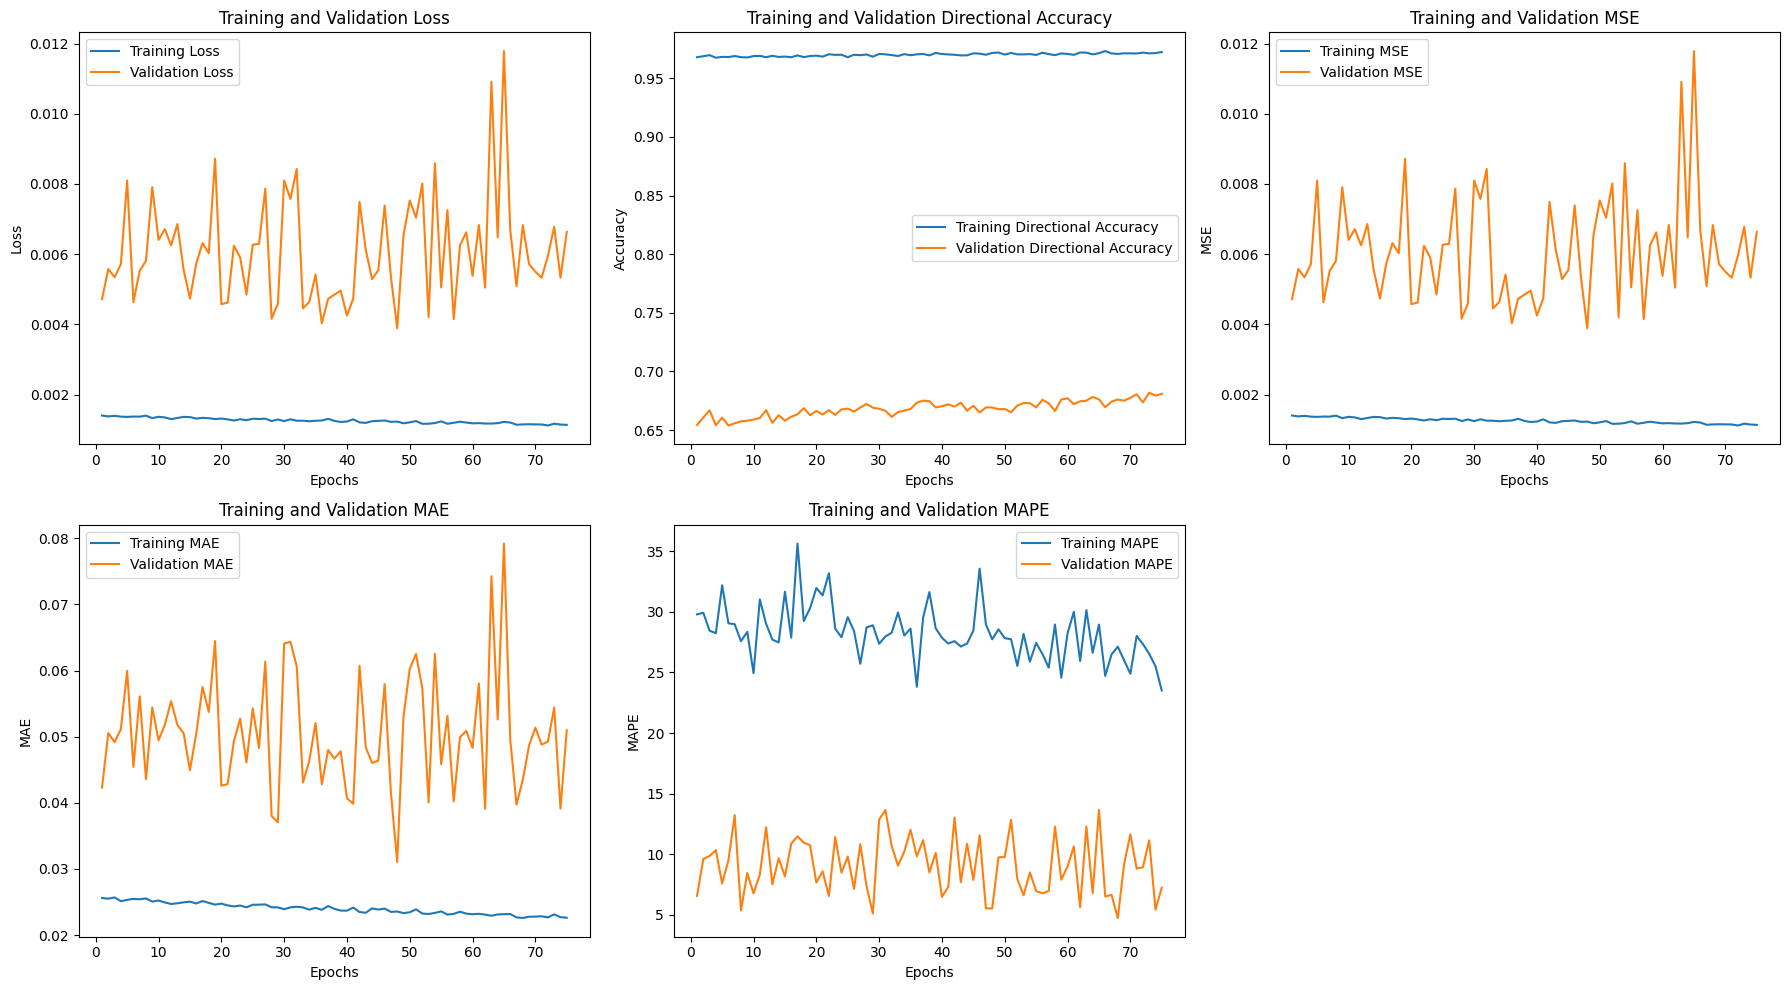

In [ ]:
metrics = history.history

# Plot training & validation metrics
epochs = range(1, len(metrics['loss']) + 1)
plt.figure(figsize=(18, 10))

# Loss
plt.subplot(2, 3, 1)
plt.plot(epochs, metrics['loss'], label='Training Loss')
plt.plot(epochs, metrics['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Directional Accuracy
plt.subplot(2, 3, 2)
plt.plot(epochs, metrics['directional_accuracy'], label='Training Directional Accuracy')
plt.plot(epochs, metrics['val_directional_accuracy'], label='Validation Directional Accuracy')
plt.title('Training and Validation Directional Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


# Mean Squared Error
plt.subplot(2, 3, 3)
plt.plot(epochs, metrics['MSE'], label='Training MSE')
plt.plot(epochs, metrics['val_MSE'], label='Validation MSE')
plt.title('Training and Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

# Mean Absolute Error
plt.subplot(2, 3, 4)
plt.plot(epochs, metrics['MAE'], label='Training MAE')
plt.plot(epochs, metrics['val_MAE'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

# Mean Absolute Percentage Error
plt.subplot(2, 3, 5)
plt.plot(epochs, metrics['MAPE'], label='Training MAPE')
plt.plot(epochs, metrics['val_MAPE'], label='Validation MAPE')
plt.title('Training and Validation MAPE')
plt.xlabel('Epochs')
plt.ylabel('MAPE')
plt.legend()

plt.tight_layout()
plt.show()